# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

In [22]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_13.h5'
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
validation_split = .1
use_skeleton = False

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%load_ext autoreload
%autoreload 2

data_generator = DataGenerator(dataset, zeros_to_nan=True)

## view sample frame

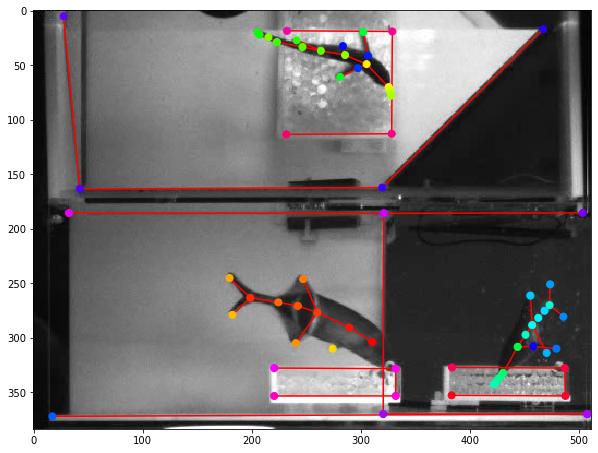

106
total frames: 475


In [24]:
frame_num = np.random.choice(len(data_generator))
image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(10,10))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)
print('total frames:', len(data_generator))

## set up image augmentation

In [25]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

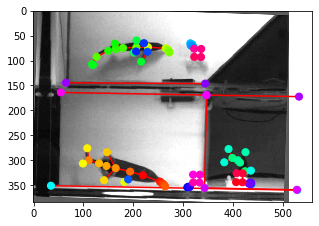

In [27]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [28]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=4,
                                    validation_split=.1, 
                                    use_graph=use_skeleton,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 428,
 'n_validation': 47,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 4,
 'output_sigma': 1.0,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_13.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 475,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# check `TrainingGenerator` output

D:\anaconda3\envs\dpk\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


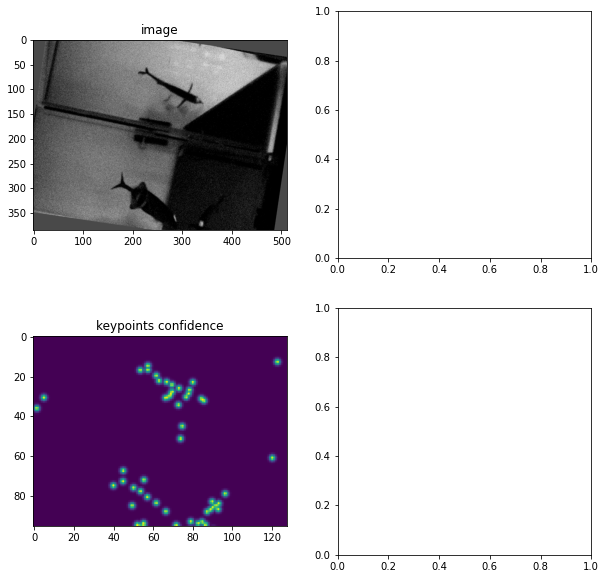

In [29]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

if use_skeleton:
    ax2.set_title('posture graph')
    ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

if use_skeleton:
    ax4.set_title('posture graph and keypoints confidence')
    ax4.imshow(outputs[0,...,-1], vmin=0)

plt.show()
train_generator.on_epoch_end()

# define a model

In [30]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 428,
 'n_validation': 47,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 108,
 'shuffle': True,
 'sigma': 4,
 'output_sigma': 1.0,
 'use_graph': False,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_13.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 475,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (108, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [19]:
batch_size = 32
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=batch_size)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 104s 10ms/sample
95.75722323558826


# define training callbacks

In [31]:
logger = Logger(validation_batch_size=2,  # make sure this isn't too big!
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""


Epoch 1/800
52/53 [============================>.] - ETA: 0s - loss: 28.8426 - output_0_loss: 9.6857 - output_1_loss: 9.6081 - output_2_loss: 9.5487evaluation_metrics: 
euclidean - mean: 52051.71 (0%:  0.16, 5%:  6.14, 25%: 159.28, 50%: 306.09, 75%: 141693.78, 95%: 141877.82, 100%: 142047.80) 
confidence - mean:  0.00 (0%: -0.00, 5%:  0.00, 25%:  0.00, 50%:  0.00, 75%:  0.00, 95%:  0.01, 100%:  0.01) 


Epoch 00001: val_loss improved from inf to 31.20361, saving model to D:\github\fish-tracking\train\models\tank_model.h5
53/53 [==============================] - 56s 1s/step - loss: 28.8143 - output_0_loss: 9.6798 - output_1_loss: 9.5977 - output_2_loss: 9.5368 - val_loss: 31.2036 - val_output_0_loss: 10.3901 - val_output_1_loss: 10.3971 - val_output_2_loss: 10.4163
Epoch 2/800
52/53 [============================>.] - ETA: 0s - loss: 26.1750 - output_0_loss: 9.2517 - output_1_loss: 8.5735 - output_2_loss: 8.3497evaluation_metrics: 
euclidean - mean: 52092.41 (0%:  0.04, 5%:  1.85, 25%: 9

Epoch 12/800
52/53 [============================>.] - ETA: 0s - loss: 16.4706 - output_0_loss: 6.9762 - output_1_loss: 5.0293 - output_2_loss: 4.4651evaluation_metrics: 
euclidean - mean: 52109.47 (0%:  0.04, 5%:  0.43, 25%:  1.42, 50%: 10.24, 75%: 141724.12, 95%: 141946.46, 100%: 142012.61) 
confidence - mean:  0.32 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.17, 75%:  0.60, 95%:  0.90, 100%:  1.30) 


Epoch 00012: val_loss improved from 19.41707 to 17.76215, saving model to D:\github\fish-tracking\train\models\tank_model.h5
53/53 [==============================] - 43s 807ms/step - loss: 16.4554 - output_0_loss: 6.9745 - output_1_loss: 5.0225 - output_2_loss: 4.4584 - val_loss: 17.7622 - val_output_0_loss: 7.4263 - val_output_1_loss: 5.4535 - val_output_2_loss: 4.8824
Epoch 13/800
52/53 [============================>.] - ETA: 0s - loss: 15.7692 - output_0_loss: 6.8000 - output_1_loss: 4.7579 - output_2_loss: 4.2113evaluation_metrics: 
euclidean - mean: 51973.79 (0%:  0.02, 5%:  0.45, 2

Epoch 23/800
52/53 [============================>.] - ETA: 0s - loss: 13.5369 - output_0_loss: 6.1944 - output_1_loss: 3.9234 - output_2_loss: 3.4191evaluation_metrics: 
euclidean - mean: 52049.88 (0%:  0.03, 5%:  0.35, 25%:  1.16, 50%:  4.91, 75%: 141719.62, 95%: 141945.85, 100%: 142013.86) 
confidence - mean:  0.40 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.34, 75%:  0.75, 95%:  0.96, 100%:  1.29) 


Epoch 00023: val_loss improved from 15.08274 to 14.59556, saving model to D:\github\fish-tracking\train\models\tank_model.h5
53/53 [==============================] - 43s 806ms/step - loss: 13.5364 - output_0_loss: 6.1977 - output_1_loss: 3.9219 - output_2_loss: 3.4167 - val_loss: 14.5956 - val_output_0_loss: 6.6202 - val_output_1_loss: 4.2384 - val_output_2_loss: 3.7370
Epoch 24/800
52/53 [============================>.] - ETA: 0s - loss: 13.3481 - output_0_loss: 6.1923 - output_1_loss: 3.8285 - output_2_loss: 3.3273evaluation_metrics: 
euclidean - mean: 51968.90 (0%:  0.04, 5%:  0.38, 2

Epoch 35/800
52/53 [============================>.] - ETA: 0s - loss: 11.8535 - output_0_loss: 5.7217 - output_1_loss: 3.2706 - output_2_loss: 2.8612evaluation_metrics: 
euclidean - mean: 51735.06 (0%:  0.03, 5%:  0.34, 25%:  1.07, 50%:  4.00, 75%: 141720.70, 95%: 141948.29, 100%: 142035.67) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.41, 75%:  0.79, 95%:  0.93, 100%:  1.11) 


Epoch 00035: val_loss improved from 13.76495 to 13.44150, saving model to D:\github\fish-tracking\train\models\tank_model.h5
53/53 [==============================] - 43s 805ms/step - loss: 11.8462 - output_0_loss: 5.7203 - output_1_loss: 3.2675 - output_2_loss: 2.8584 - val_loss: 13.4415 - val_output_0_loss: 6.1846 - val_output_1_loss: 3.8168 - val_output_2_loss: 3.4401
Epoch 36/800
52/53 [============================>.] - ETA: 0s - loss: 11.8641 - output_0_loss: 5.7105 - output_1_loss: 3.2707 - output_2_loss: 2.8829evaluation_metrics: 
euclidean - mean: 52049.55 (0%:  0.00, 5%:  0.39, 2

53/53 [==============================] - 43s 809ms/step - loss: 11.0472 - output_0_loss: 5.4071 - output_1_loss: 3.0003 - output_2_loss: 2.6397 - val_loss: 12.7001 - val_output_0_loss: 5.9437 - val_output_1_loss: 3.5546 - val_output_2_loss: 3.2018
Epoch 47/800
52/53 [============================>.] - ETA: 0s - loss: 11.0372 - output_0_loss: 5.3803 - output_1_loss: 3.0102 - output_2_loss: 2.6467evaluation_metrics: 
euclidean - mean: 51626.84 (0%:  0.00, 5%:  0.35, 25%:  1.10, 50%:  4.28, 75%: 141761.34, 95%: 141945.41, 100%: 142009.88) 
confidence - mean:  0.42 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.43, 75%:  0.79, 95%:  0.93, 100%:  1.12) 


Epoch 00047: val_loss did not improve from 12.70011
53/53 [==============================] - 42s 799ms/step - loss: 11.0448 - output_0_loss: 5.3823 - output_1_loss: 3.0125 - output_2_loss: 2.6501 - val_loss: 13.4293 - val_output_0_loss: 6.1312 - val_output_1_loss: 3.8046 - val_output_2_loss: 3.4935
Epoch 48/800
52/53 [==========================

52/53 [============================>.] - ETA: 0s - loss: 10.6116 - output_0_loss: 5.1900 - output_1_loss: 2.8869 - output_2_loss: 2.5348evaluation_metrics: 
euclidean - mean: 52102.00 (0%:  0.00, 5%:  0.34, 25%:  1.04, 50%:  3.67, 75%: 141718.66, 95%: 141943.33, 100%: 142014.94) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.47, 75%:  0.80, 95%:  0.94, 100%:  1.16) 


Epoch 00058: val_loss did not improve from 12.32459
53/53 [==============================] - 43s 807ms/step - loss: 10.5997 - output_0_loss: 5.1916 - output_1_loss: 2.8802 - output_2_loss: 2.5279 - val_loss: 12.6534 - val_output_0_loss: 5.8863 - val_output_1_loss: 3.5267 - val_output_2_loss: 3.2405
Epoch 59/800
52/53 [============================>.] - ETA: 0s - loss: 10.5262 - output_0_loss: 5.1475 - output_1_loss: 2.8641 - output_2_loss: 2.5146evaluation_metrics: 
euclidean - mean: 52160.89 (0%:  0.00, 5%:  0.36, 25%:  1.11, 50%:  3.82, 75%: 141728.52, 95%: 141950.24, 100%: 142034.20) 
confidence - 

Epoch 70/800
52/53 [============================>.] - ETA: 0s - loss: 9.9809 - output_0_loss: 4.9706 - output_1_loss: 2.6792 - output_2_loss: 2.3311 evaluation_metrics: 
euclidean - mean: 52131.62 (0%:  0.03, 5%:  0.30, 25%:  0.99, 50%:  3.87, 75%: 141734.71, 95%: 141944.28, 100%: 142016.51) 
confidence - mean:  0.43 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.48, 75%:  0.80, 95%:  0.94, 100%:  1.15) 


Epoch 00070: val_loss did not improve from 12.19845
53/53 [==============================] - 42s 801ms/step - loss: 10.0039 - output_0_loss: 4.9771 - output_1_loss: 2.6868 - output_2_loss: 2.3400 - val_loss: 12.2547 - val_output_0_loss: 5.5930 - val_output_1_loss: 3.4392 - val_output_2_loss: 3.2226
Epoch 71/800
52/53 [============================>.] - ETA: 0s - loss: 9.8864 - output_0_loss: 4.9290 - output_1_loss: 2.6561 - output_2_loss: 2.3013evaluation_metrics: 
euclidean - mean: 52107.65 (0%:  0.03, 5%:  0.38, 25%:  1.11, 50%:  4.16, 75%: 141727.17, 95%: 141949.57, 100%: 142045.39) 
c

Epoch 82/800
52/53 [============================>.] - ETA: 0s - loss: 9.3698 - output_0_loss: 4.7139 - output_1_loss: 2.5124 - output_2_loss: 2.1435evaluation_metrics: 
euclidean - mean: 51733.49 (0%:  0.04, 5%:  0.33, 25%:  1.04, 50%:  3.52, 75%: 141739.24, 95%: 141954.75, 100%: 142015.16) 
confidence - mean:  0.44 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.52, 75%:  0.82, 95%:  0.93, 100%:  1.10) 


Epoch 00082: val_loss did not improve from 11.68528
53/53 [==============================] - 42s 801ms/step - loss: 9.3659 - output_0_loss: 4.7114 - output_1_loss: 2.5113 - output_2_loss: 2.1432 - val_loss: 11.7458 - val_output_0_loss: 5.4592 - val_output_1_loss: 3.2785 - val_output_2_loss: 3.0081
Epoch 83/800
52/53 [============================>.] - ETA: 0s - loss: 9.3768 - output_0_loss: 4.6878 - output_1_loss: 2.5214 - output_2_loss: 2.1676evaluation_metrics: 
euclidean - mean: 52245.28 (0%:  0.02, 5%:  0.39, 25%:  1.16, 50%:  4.00, 75%: 141726.71, 95%: 141946.23, 100%: 142014.54) 
con

53/53 [==============================] - 43s 805ms/step - loss: 9.1972 - output_0_loss: 4.5715 - output_1_loss: 2.4977 - output_2_loss: 2.1280 - val_loss: 11.3811 - val_output_0_loss: 5.1878 - val_output_1_loss: 3.2479 - val_output_2_loss: 2.9454
Epoch 94/800
52/53 [============================>.] - ETA: 0s - loss: 9.1296 - output_0_loss: 4.5322 - output_1_loss: 2.4805 - output_2_loss: 2.1169evaluation_metrics: 
euclidean - mean: 52158.87 (0%:  0.00, 5%:  0.33, 25%:  1.16, 50%:  4.64, 75%: 141726.92, 95%: 141947.71, 100%: 142015.40) 
confidence - mean:  0.41 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.36, 75%:  0.80, 95%:  0.94, 100%:  1.08) 


Epoch 00094: val_loss did not improve from 11.38110
53/53 [==============================] - 42s 801ms/step - loss: 9.1517 - output_0_loss: 4.5493 - output_1_loss: 2.4851 - output_2_loss: 2.1174 - val_loss: 13.1492 - val_output_0_loss: 5.7558 - val_output_1_loss: 3.8447 - val_output_2_loss: 3.5487
Epoch 95/800
52/53 [============================>

52/53 [============================>.] - ETA: 0s - loss: 8.9288 - output_0_loss: 4.4632 - output_1_loss: 2.4245 - output_2_loss: 2.0410evaluation_metrics: 
euclidean - mean: 51871.80 (0%:  0.00, 5%:  0.32, 25%:  1.00, 50%:  3.66, 75%: 141724.69, 95%: 141946.17, 100%: 142013.52) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.53, 75%:  0.81, 95%:  0.94, 100%:  1.13) 


Epoch 00105: val_loss did not improve from 11.20340
53/53 [==============================] - 42s 798ms/step - loss: 8.9110 - output_0_loss: 4.4566 - output_1_loss: 2.4191 - output_2_loss: 2.0352 - val_loss: 11.7215 - val_output_0_loss: 5.2919 - val_output_1_loss: 3.3301 - val_output_2_loss: 3.0995
Epoch 106/800
52/53 [============================>.] - ETA: 0s - loss: 8.9588 - output_0_loss: 4.4512 - output_1_loss: 2.4429 - output_2_loss: 2.0648evaluation_metrics: 
euclidean - mean: 51790.50 (0%:  0.01, 5%:  0.37, 25%:  1.27, 50%:  6.63, 75%: 141719.01, 95%: 141949.06, 100%: 142015.84) 
confidence - me

Epoch 117/800
52/53 [============================>.] - ETA: 0s - loss: 8.5043 - output_0_loss: 4.2766 - output_1_loss: 2.2955 - output_2_loss: 1.9322evaluation_metrics: 
euclidean - mean: 50790.12 (0%:  0.00, 5%:  0.36, 25%:  1.15, 50%:  4.01, 75%: 141730.70, 95%: 141948.06, 100%: 142043.10) 
confidence - mean:  0.44 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.50, 75%:  0.80, 95%:  0.93, 100%:  1.11) 


Epoch 00117: val_loss did not improve from 10.88422
53/53 [==============================] - 42s 801ms/step - loss: 8.5338 - output_0_loss: 4.2862 - output_1_loss: 2.3048 - output_2_loss: 1.9428 - val_loss: 12.7753 - val_output_0_loss: 5.8257 - val_output_1_loss: 3.6091 - val_output_2_loss: 3.3405
Epoch 118/800
52/53 [============================>.] - ETA: 0s - loss: 8.4946 - output_0_loss: 4.2729 - output_1_loss: 2.2875 - output_2_loss: 1.9342evaluation_metrics: 
euclidean - mean: 52042.39 (0%:  0.00, 5%:  0.35, 25%:  1.04, 50%:  3.92, 75%: 141718.10, 95%: 141946.59, 100%: 142013.80) 
c

Epoch 129/800
52/53 [============================>.] - ETA: 0s - loss: 9.0373 - output_0_loss: 4.4716 - output_1_loss: 2.4735 - output_2_loss: 2.0921evaluation_metrics: 
euclidean - mean: 52009.05 (0%:  0.03, 5%:  0.34, 25%:  1.03, 50%:  3.31, 75%: 141717.26, 95%: 141949.31, 100%: 142038.24) 
confidence - mean:  0.45 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.55, 75%:  0.81, 95%:  0.93, 100%:  1.20) 


Epoch 00129: val_loss did not improve from 10.51966
53/53 [==============================] - 42s 798ms/step - loss: 9.0326 - output_0_loss: 4.4645 - output_1_loss: 2.4732 - output_2_loss: 2.0949 - val_loss: 11.2352 - val_output_0_loss: 5.1669 - val_output_1_loss: 3.1833 - val_output_2_loss: 2.8849
Epoch 130/800
52/53 [============================>.] - ETA: 0s - loss: 8.5929 - output_0_loss: 4.3214 - output_1_loss: 2.3235 - output_2_loss: 1.9479evaluation_metrics: 
euclidean - mean: 52097.45 (0%:  0.01, 5%:  0.38, 25%:  1.01, 50%:  3.40, 75%: 141715.84, 95%: 141950.52, 100%: 142034.93) 
c

Epoch 141/800
52/53 [============================>.] - ETA: 0s - loss: 8.1072 - output_0_loss: 4.0816 - output_1_loss: 2.1795 - output_2_loss: 1.8461evaluation_metrics: 
euclidean - mean: 51616.63 (0%:  0.00, 5%:  0.31, 25%:  1.02, 50%:  3.47, 75%: 141729.52, 95%: 141953.76, 100%: 142036.09) 
confidence - mean:  0.46 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.55, 75%:  0.82, 95%:  0.94, 100%:  1.19) 


Epoch 00141: val_loss did not improve from 10.51966
53/53 [==============================] - 42s 800ms/step - loss: 8.1147 - output_0_loss: 4.0859 - output_1_loss: 2.1815 - output_2_loss: 1.8473 - val_loss: 11.0483 - val_output_0_loss: 4.9486 - val_output_1_loss: 3.1650 - val_output_2_loss: 2.9347
Epoch 142/800
52/53 [============================>.] - ETA: 0s - loss: 8.4235 - output_0_loss: 4.2002 - output_1_loss: 2.2830 - output_2_loss: 1.9403evaluation_metrics: 
euclidean - mean: 52359.67 (0%:  0.00, 5%:  0.30, 25%:  0.97, 50%:  3.37, 75%: 141736.93, 95%: 141953.15, 100%: 142035.69) 
c

Epoch 153/800
52/53 [============================>.] - ETA: 0s - loss: 7.8380 - output_0_loss: 3.9812 - output_1_loss: 2.0916 - output_2_loss: 1.7652evaluation_metrics: 
euclidean - mean: 52356.30 (0%:  0.00, 5%:  0.28, 25%:  1.00, 50%:  3.31, 75%: 141731.05, 95%: 141943.92, 100%: 142038.01) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.61, 75%:  0.85, 95%:  0.96, 100%:  1.12) 


Epoch 00153: val_loss did not improve from 10.18321
53/53 [==============================] - 42s 797ms/step - loss: 7.8445 - output_0_loss: 3.9856 - output_1_loss: 2.0933 - output_2_loss: 1.7657 - val_loss: 10.4043 - val_output_0_loss: 4.7259 - val_output_1_loss: 2.9665 - val_output_2_loss: 2.7118
Epoch 154/800
52/53 [============================>.] - ETA: 0s - loss: 7.8896 - output_0_loss: 3.9926 - output_1_loss: 2.1158 - output_2_loss: 1.7811evaluation_metrics: 
euclidean - mean: 51985.70 (0%:  0.03, 5%:  0.31, 25%:  0.95, 50%:  3.19, 75%: 141730.58, 95%: 141947.81, 100%: 142015.82) 
c

Epoch 165/800
52/53 [============================>.] - ETA: 0s - loss: 7.9440 - output_0_loss: 3.9970 - output_1_loss: 2.1393 - output_2_loss: 1.8077evaluation_metrics: 
euclidean - mean: 51619.24 (0%:  0.00, 5%:  0.31, 25%:  0.97, 50%:  3.20, 75%: 141734.73, 95%: 141955.30, 100%: 142045.36) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.64, 75%:  0.85, 95%:  0.96, 100%:  1.15) 


Epoch 00165: val_loss did not improve from 10.18321
53/53 [==============================] - 42s 797ms/step - loss: 7.9362 - output_0_loss: 3.9956 - output_1_loss: 2.1363 - output_2_loss: 1.8044 - val_loss: 10.4865 - val_output_0_loss: 4.7478 - val_output_1_loss: 2.9605 - val_output_2_loss: 2.7782
Epoch 166/800
52/53 [============================>.] - ETA: 0s - loss: 7.6474 - output_0_loss: 3.8876 - output_1_loss: 2.0395 - output_2_loss: 1.7203evaluation_metrics: 
euclidean - mean: 52015.26 (0%:  0.00, 5%:  0.29, 25%:  1.03, 50%:  3.32, 75%: 141733.20, 95%: 141954.04, 100%: 142036.74) 
c

Epoch 177/800
52/53 [============================>.] - ETA: 0s - loss: 7.4905 - output_0_loss: 3.7900 - output_1_loss: 2.0136 - output_2_loss: 1.6868evaluation_metrics: 
euclidean - mean: 52130.44 (0%:  0.03, 5%:  0.32, 25%:  0.98, 50%:  3.37, 75%: 141733.74, 95%: 141946.56, 100%: 142044.43) 
confidence - mean:  0.48 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.62, 75%:  0.85, 95%:  0.96, 100%:  1.12) 


Epoch 00177: val_loss did not improve from 10.10573
53/53 [==============================] - 42s 798ms/step - loss: 7.4847 - output_0_loss: 3.7896 - output_1_loss: 2.0108 - output_2_loss: 1.6843 - val_loss: 10.4457 - val_output_0_loss: 4.7384 - val_output_1_loss: 2.9253 - val_output_2_loss: 2.7820
Epoch 178/800
52/53 [============================>.] - ETA: 0s - loss: 7.6809 - output_0_loss: 3.8627 - output_1_loss: 2.0647 - output_2_loss: 1.7535evaluation_metrics: 
euclidean - mean: 52044.82 (0%:  0.00, 5%:  0.29, 25%:  0.95, 50%:  3.14, 75%: 141728.24, 95%: 141951.62, 100%: 142042.76) 
c

Epoch 189/800
52/53 [============================>.] - ETA: 0s - loss: 7.5217 - output_0_loss: 3.8245 - output_1_loss: 2.0117 - output_2_loss: 1.6855evaluation_metrics: 
euclidean - mean: 52126.64 (0%:  0.04, 5%:  0.29, 25%:  0.94, 50%:  3.27, 75%: 141725.03, 95%: 141948.40, 100%: 142046.21) 
confidence - mean:  0.49 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.65, 75%:  0.85, 95%:  0.95, 100%:  1.23) 


Epoch 00189: val_loss did not improve from 9.86119
53/53 [==============================] - 42s 798ms/step - loss: 7.5013 - output_0_loss: 3.8193 - output_1_loss: 2.0042 - output_2_loss: 1.6779 - val_loss: 10.0893 - val_output_0_loss: 4.4821 - val_output_1_loss: 2.8731 - val_output_2_loss: 2.7341
Epoch 190/800
52/53 [============================>.] - ETA: 0s - loss: 7.4713 - output_0_loss: 3.7894 - output_1_loss: 2.0044 - output_2_loss: 1.6776evaluation_metrics: 
euclidean - mean: 51756.76 (0%:  0.00, 5%:  0.30, 25%:  0.96, 50%:  3.13, 75%: 141732.88, 95%: 141951.99, 100%: 142037.56) 
co

53/53 [==============================] - 43s 808ms/step - loss: 7.0143 - output_0_loss: 3.6230 - output_1_loss: 1.8516 - output_2_loss: 1.5397 - val_loss: 9.5800 - val_output_0_loss: 4.2583 - val_output_1_loss: 2.7374 - val_output_2_loss: 2.5843
Epoch 201/800
52/53 [============================>.] - ETA: 0s - loss: 6.9063 - output_0_loss: 3.6131 - output_1_loss: 1.8082 - output_2_loss: 1.4850evaluation_metrics: 
euclidean - mean: 52329.41 (0%:  0.00, 5%:  0.26, 25%:  0.89, 50%:  3.07, 75%: 141732.18, 95%: 141949.19, 100%: 142035.55) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.68, 75%:  0.87, 95%:  0.96, 100%:  1.12) 


Epoch 00201: val_loss improved from 9.57998 to 9.45667, saving model to D:\github\fish-tracking\train\models\tank_model.h5
53/53 [==============================] - 43s 806ms/step - loss: 6.9068 - output_0_loss: 3.6121 - output_1_loss: 1.8090 - output_2_loss: 1.4857 - val_loss: 9.4567 - val_output_0_loss: 4.2140 - val_output_1_loss: 2.7031 - val_o

Epoch 212/800
52/53 [============================>.] - ETA: 0s - loss: 6.6665 - output_0_loss: 3.5045 - output_1_loss: 1.7417 - output_2_loss: 1.4203evaluation_metrics: 
euclidean - mean: 51961.44 (0%:  0.00, 5%:  0.24, 25%:  0.88, 50%:  2.92, 75%: 141754.31, 95%: 141954.84, 100%: 142047.71) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00212: val_loss did not improve from 9.14334
53/53 [==============================] - 42s 800ms/step - loss: 6.6476 - output_0_loss: 3.4981 - output_1_loss: 1.7350 - output_2_loss: 1.4145 - val_loss: 9.1788 - val_output_0_loss: 4.1031 - val_output_1_loss: 2.6221 - val_output_2_loss: 2.4536
Epoch 213/800
52/53 [============================>.] - ETA: 0s - loss: 6.5698 - output_0_loss: 3.4745 - output_1_loss: 1.7072 - output_2_loss: 1.3881evaluation_metrics: 
euclidean - mean: 51758.18 (0%:  0.00, 5%:  0.25, 25%:  0.88, 50%:  2.91, 75%: 141734.61, 95%: 141952.23, 100%: 142047.63) 
con

Epoch 224/800
52/53 [============================>.] - ETA: 0s - loss: 6.3820 - output_0_loss: 3.4148 - output_1_loss: 1.6440 - output_2_loss: 1.3231evaluation_metrics: 
euclidean - mean: 52074.60 (0%:  0.00, 5%:  0.24, 25%:  0.88, 50%:  2.90, 75%: 141751.39, 95%: 141953.63, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.68, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00224: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00224: val_loss did not improve from 9.14334
53/53 [==============================] - 42s 799ms/step - loss: 6.3895 - output_0_loss: 3.4176 - output_1_loss: 1.6468 - output_2_loss: 1.3251 - val_loss: 9.1793 - val_output_0_loss: 4.1094 - val_output_1_loss: 2.6179 - val_output_2_loss: 2.4520
Epoch 225/800
52/53 [============================>.] - ETA: 0s - loss: 6.3452 - output_0_loss: 3.3898 - output_1_loss: 1.6403 - output_2_loss: 1.3151evaluation_metrics: 
euclidean - mean: 52304.17 (0%:  0.00, 5%:  0

Epoch 236/800
52/53 [============================>.] - ETA: 0s - loss: 6.3396 - output_0_loss: 3.3890 - output_1_loss: 1.6339 - output_2_loss: 1.3166evaluation_metrics: 
euclidean - mean: 52102.55 (0%:  0.00, 5%:  0.23, 25%:  0.89, 50%:  2.92, 75%: 141738.87, 95%: 141954.88, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.68, 75%:  0.87, 95%:  0.96, 100%:  1.09) 


Epoch 00236: val_loss did not improve from 9.08921
53/53 [==============================] - 43s 805ms/step - loss: 6.3610 - output_0_loss: 3.4010 - output_1_loss: 1.6389 - output_2_loss: 1.3212 - val_loss: 9.1419 - val_output_0_loss: 4.0770 - val_output_1_loss: 2.6144 - val_output_2_loss: 2.4506
Epoch 237/800
52/53 [============================>.] - ETA: 0s - loss: 6.2558 - output_0_loss: 3.3466 - output_1_loss: 1.6145 - output_2_loss: 1.2947evaluation_metrics: 
euclidean - mean: 52103.76 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.87, 75%: 141751.28, 95%: 141954.56, 100%: 142047.46) 
con

Epoch 248/800
52/53 [============================>.] - ETA: 0s - loss: 6.2487 - output_0_loss: 3.3702 - output_1_loss: 1.6005 - output_2_loss: 1.2780evaluation_metrics: 
euclidean - mean: 51759.66 (0%:  0.03, 5%:  0.23, 25%:  0.87, 50%:  2.80, 75%: 141743.63, 95%: 141954.13, 100%: 142047.49) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.09) 


Epoch 00248: val_loss did not improve from 9.08921
53/53 [==============================] - 42s 802ms/step - loss: 6.2725 - output_0_loss: 3.3787 - output_1_loss: 1.6084 - output_2_loss: 1.2854 - val_loss: 9.1254 - val_output_0_loss: 4.0833 - val_output_1_loss: 2.6036 - val_output_2_loss: 2.4385
Epoch 249/800
52/53 [============================>.] - ETA: 0s - loss: 6.2370 - output_0_loss: 3.3552 - output_1_loss: 1.5978 - output_2_loss: 1.2840evaluation_metrics: 
euclidean - mean: 52245.18 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.95, 75%: 141748.07, 95%: 141954.45, 100%: 142047.51) 
con

Epoch 260/800
52/53 [============================>.] - ETA: 0s - loss: 6.2007 - output_0_loss: 3.3612 - output_1_loss: 1.5818 - output_2_loss: 1.2577evaluation_metrics: 
euclidean - mean: 52016.69 (0%:  0.00, 5%:  0.24, 25%:  0.89, 50%:  2.93, 75%: 141743.89, 95%: 141954.95, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.68, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00260: val_loss did not improve from 8.98908
53/53 [==============================] - 42s 799ms/step - loss: 6.2087 - output_0_loss: 3.3631 - output_1_loss: 1.5843 - output_2_loss: 1.2612 - val_loss: 9.1756 - val_output_0_loss: 4.1113 - val_output_1_loss: 2.6189 - val_output_2_loss: 2.4453
Epoch 261/800
52/53 [============================>.] - ETA: 0s - loss: 6.1751 - output_0_loss: 3.3319 - output_1_loss: 1.5801 - output_2_loss: 1.2631evaluation_metrics: 
euclidean - mean: 51959.41 (0%:  0.02, 5%:  0.23, 25%:  0.88, 50%:  2.89, 75%: 141741.28, 95%: 141954.96, 100%: 142047.49) 
con

Epoch 272/800
52/53 [============================>.] - ETA: 0s - loss: 6.1070 - output_0_loss: 3.3022 - output_1_loss: 1.5582 - output_2_loss: 1.2466evaluation_metrics: 
euclidean - mean: 52302.37 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.91, 75%: 141748.36, 95%: 141954.73, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00272: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00272: val_loss did not improve from 8.98908
53/53 [==============================] - 42s 801ms/step - loss: 6.0963 - output_0_loss: 3.2947 - output_1_loss: 1.5557 - output_2_loss: 1.2458 - val_loss: 9.0728 - val_output_0_loss: 4.0599 - val_output_1_loss: 2.5828 - val_output_2_loss: 2.4302
Epoch 273/800
52/53 [============================>.] - ETA: 0s - loss: 6.1616 - output_0_loss: 3.3146 - output_1_loss: 1.5829 - output_2_loss: 1.2642evaluation_metrics: 
euclidean - mean: 51616.38 (0%:  0.00, 5%:  0

Epoch 284/800
52/53 [============================>.] - ETA: 0s - loss: 6.1752 - output_0_loss: 3.3249 - output_1_loss: 1.5826 - output_2_loss: 1.2677evaluation_metrics: 
euclidean - mean: 52358.77 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.88, 75%: 141746.95, 95%: 141954.62, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00284: val_loss did not improve from 8.98908
53/53 [==============================] - 42s 800ms/step - loss: 6.1672 - output_0_loss: 3.3214 - output_1_loss: 1.5802 - output_2_loss: 1.2655 - val_loss: 9.1863 - val_output_0_loss: 4.1036 - val_output_1_loss: 2.6232 - val_output_2_loss: 2.4595
Epoch 285/800
52/53 [============================>.] - ETA: 0s - loss: 6.1062 - output_0_loss: 3.3122 - output_1_loss: 1.5576 - output_2_loss: 1.2364evaluation_metrics: 
euclidean - mean: 51616.25 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.78, 75%: 141734.58, 95%: 141954.65, 100%: 142047.57) 
con

Epoch 296/800
52/53 [============================>.] - ETA: 0s - loss: 6.2309 - output_0_loss: 3.3463 - output_1_loss: 1.6015 - output_2_loss: 1.2831evaluation_metrics: 
euclidean - mean: 52416.19 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.96, 75%: 141744.14, 95%: 141954.67, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00296: val_loss did not improve from 8.98908
53/53 [==============================] - 42s 801ms/step - loss: 6.2292 - output_0_loss: 3.3471 - output_1_loss: 1.6002 - output_2_loss: 1.2819 - val_loss: 9.1719 - val_output_0_loss: 4.0852 - val_output_1_loss: 2.6281 - val_output_2_loss: 2.4586
Epoch 297/800
52/53 [============================>.] - ETA: 0s - loss: 6.2363 - output_0_loss: 3.3496 - output_1_loss: 1.6006 - output_2_loss: 1.2861evaluation_metrics: 
euclidean - mean: 52245.23 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.96, 75%: 141747.01, 95%: 141955.06, 100%: 142047.54) 
con

Epoch 308/800
52/53 [============================>.] - ETA: 0s - loss: 6.2722 - output_0_loss: 3.3651 - output_1_loss: 1.6117 - output_2_loss: 1.2955evaluation_metrics: 
euclidean - mean: 51759.85 (0%:  0.01, 5%:  0.23, 25%:  0.87, 50%:  2.81, 75%: 141743.11, 95%: 141954.19, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00308: val_loss did not improve from 8.98908
53/53 [==============================] - 42s 800ms/step - loss: 6.2782 - output_0_loss: 3.3618 - output_1_loss: 1.6157 - output_2_loss: 1.3006 - val_loss: 9.2202 - val_output_0_loss: 4.1185 - val_output_1_loss: 2.6310 - val_output_2_loss: 2.4706
Epoch 309/800
52/53 [============================>.] - ETA: 0s - loss: 6.1976 - output_0_loss: 3.3357 - output_1_loss: 1.5888 - output_2_loss: 1.2731evaluation_metrics: 
euclidean - mean: 52045.41 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.88, 75%: 141747.69, 95%: 141954.68, 100%: 142047.54) 
con

Epoch 320/800
52/53 [============================>.] - ETA: 0s - loss: 6.2412 - output_0_loss: 3.3387 - output_1_loss: 1.6089 - output_2_loss: 1.2936evaluation_metrics: 
euclidean - mean: 51731.95 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.87, 75%: 141743.15, 95%: 141955.13, 100%: 142047.57) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00320: val_loss did not improve from 8.98908
53/53 [==============================] - 43s 803ms/step - loss: 6.2266 - output_0_loss: 3.3323 - output_1_loss: 1.6040 - output_2_loss: 1.2903 - val_loss: 9.1215 - val_output_0_loss: 4.0891 - val_output_1_loss: 2.5956 - val_output_2_loss: 2.4368
Epoch 321/800
52/53 [============================>.] - ETA: 0s - loss: 6.3100 - output_0_loss: 3.3794 - output_1_loss: 1.6271 - output_2_loss: 1.3036evaluation_metrics: 
euclidean - mean: 52073.98 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.90, 75%: 141745.46, 95%: 141955.12, 100%: 142047.57) 
con

Epoch 332/800
52/53 [============================>.] - ETA: 0s - loss: 6.1811 - output_0_loss: 3.3295 - output_1_loss: 1.5870 - output_2_loss: 1.2646evaluation_metrics: 
euclidean - mean: 51731.56 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.86, 75%: 141738.83, 95%: 141955.00, 100%: 142047.57) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00332: val_loss did not improve from 8.98143
53/53 [==============================] - 43s 803ms/step - loss: 6.1810 - output_0_loss: 3.3296 - output_1_loss: 1.5871 - output_2_loss: 1.2643 - val_loss: 9.1865 - val_output_0_loss: 4.1054 - val_output_1_loss: 2.6232 - val_output_2_loss: 2.4579
Epoch 333/800
52/53 [============================>.] - ETA: 0s - loss: 6.3667 - output_0_loss: 3.3886 - output_1_loss: 1.6493 - output_2_loss: 1.3288evaluation_metrics: 
euclidean - mean: 52359.06 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.96, 75%: 141745.49, 95%: 141954.68, 100%: 142047.57) 
con

Epoch 344/800
52/53 [============================>.] - ETA: 0s - loss: 6.1512 - output_0_loss: 3.3234 - output_1_loss: 1.5730 - output_2_loss: 1.2549evaluation_metrics: 
euclidean - mean: 52102.31 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.94, 75%: 141743.11, 95%: 141955.16, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00344: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 798ms/step - loss: 6.1595 - output_0_loss: 3.3285 - output_1_loss: 1.5750 - output_2_loss: 1.2560 - val_loss: 9.1661 - val_output_0_loss: 4.0969 - val_output_1_loss: 2.6183 - val_output_2_loss: 2.4510
Epoch 345/800
52/53 [============================>.] - ETA: 0s - loss: 6.2868 - output_0_loss: 3.3685 - output_1_loss: 1.6171 - output_2_loss: 1.3012evaluation_metrics: 
euclidean - mean: 52102.16 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.94, 75%: 141740.90, 95%: 141954.69, 100%: 142047.54) 
con

Epoch 356/800
52/53 [============================>.] - ETA: 0s - loss: 6.3109 - output_0_loss: 3.3592 - output_1_loss: 1.6347 - output_2_loss: 1.3170evaluation_metrics: 
euclidean - mean: 52102.17 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.93, 75%: 141740.86, 95%: 141954.86, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.68, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00356: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 795ms/step - loss: 6.2909 - output_0_loss: 3.3529 - output_1_loss: 1.6279 - output_2_loss: 1.3101 - val_loss: 9.1718 - val_output_0_loss: 4.1105 - val_output_1_loss: 2.6176 - val_output_2_loss: 2.4437
Epoch 357/800
52/53 [============================>.] - ETA: 0s - loss: 6.3490 - output_0_loss: 3.3959 - output_1_loss: 1.6414 - output_2_loss: 1.3116evaluation_metrics: 
euclidean - mean: 52358.87 (0%:  0.00, 5%:  0.23, 25%:  0.89, 50%:  2.95, 75%: 141743.09, 95%: 141954.68, 100%: 142047.57) 
con

Epoch 368/800
52/53 [============================>.] - ETA: 0s - loss: 6.2498 - output_0_loss: 3.3662 - output_1_loss: 1.6013 - output_2_loss: 1.2824evaluation_metrics: 
euclidean - mean: 51018.84 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.75, 75%: 141740.91, 95%: 141955.20, 100%: 142047.54) 
confidence - mean:  0.51 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.70, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00368: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 796ms/step - loss: 6.2456 - output_0_loss: 3.3680 - output_1_loss: 1.5984 - output_2_loss: 1.2792 - val_loss: 9.1938 - val_output_0_loss: 4.1261 - val_output_1_loss: 2.6187 - val_output_2_loss: 2.4490
Epoch 369/800
52/53 [============================>.] - ETA: 0s - loss: 6.1631 - output_0_loss: 3.3456 - output_1_loss: 1.5672 - output_2_loss: 1.2503evaluation_metrics: 
euclidean - mean: 52045.14 (0%:  0.00, 5%:  0.23, 25%:  0.89, 50%:  2.92, 75%: 141738.98, 95%: 141955.19, 100%: 142047.57) 
con

Epoch 380/800
52/53 [============================>.] - ETA: 0s - loss: 6.3193 - output_0_loss: 3.3976 - output_1_loss: 1.6234 - output_2_loss: 1.2983evaluation_metrics: 
euclidean - mean: 52130.85 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.88, 75%: 141743.20, 95%: 141954.98, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00380: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 795ms/step - loss: 6.3098 - output_0_loss: 3.3924 - output_1_loss: 1.6207 - output_2_loss: 1.2967 - val_loss: 9.1406 - val_output_0_loss: 4.0659 - val_output_1_loss: 2.6175 - val_output_2_loss: 2.4572
Epoch 381/800
52/53 [============================>.] - ETA: 0s - loss: 6.2788 - output_0_loss: 3.3637 - output_1_loss: 1.6164 - output_2_loss: 1.2988evaluation_metrics: 
euclidean - mean: 52044.95 (0%:  0.03, 5%:  0.23, 25%:  0.88, 50%:  2.91, 75%: 141738.81, 95%: 141953.72, 100%: 142047.54) 
con

Epoch 392/800
52/53 [============================>.] - ETA: 0s - loss: 6.0108 - output_0_loss: 3.2622 - output_1_loss: 1.5314 - output_2_loss: 1.2173evaluation_metrics: 
euclidean - mean: 51988.34 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.87, 75%: 141746.79, 95%: 141953.77, 100%: 142047.54) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00392: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 795ms/step - loss: 6.0000 - output_0_loss: 3.2614 - output_1_loss: 1.5263 - output_2_loss: 1.2123 - val_loss: 9.2154 - val_output_0_loss: 4.1183 - val_output_1_loss: 2.6292 - val_output_2_loss: 2.4680
Epoch 393/800
52/53 [============================>.] - ETA: 0s - loss: 6.1771 - output_0_loss: 3.3329 - output_1_loss: 1.5791 - output_2_loss: 1.2651evaluation_metrics: 
euclidean - mean: 52130.52 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.88, 75%: 141738.32, 95%: 141954.70, 100%: 142047.54) 
con

Epoch 404/800
52/53 [============================>.] - ETA: 0s - loss: 6.1611 - output_0_loss: 3.3625 - output_1_loss: 1.5611 - output_2_loss: 1.2376evaluation_metrics: 
euclidean - mean: 52073.86 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.88, 75%: 141743.19, 95%: 141954.69, 100%: 142047.51) 
confidence - mean:  0.50 (0%:  0.00, 5%:  0.00, 25%:  0.02, 50%:  0.69, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00404: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 799ms/step - loss: 6.1743 - output_0_loss: 3.3645 - output_1_loss: 1.5668 - output_2_loss: 1.2431 - val_loss: 9.2115 - val_output_0_loss: 4.1144 - val_output_1_loss: 2.6281 - val_output_2_loss: 2.4690
Epoch 405/800
52/53 [============================>.] - ETA: 0s - loss: 6.3092 - output_0_loss: 3.3943 - output_1_loss: 1.6167 - output_2_loss: 1.2981evaluation_metrics: 
euclidean - mean: 51846.00 (0%:  0.00, 5%:  0.23, 25%:  0.87, 50%:  2.84, 75%: 141743.12, 95%: 141953.97, 100%: 142047.54) 
con

Epoch 416/800
52/53 [============================>.] - ETA: 0s - loss: 6.3302 - output_0_loss: 3.3729 - output_1_loss: 1.6353 - output_2_loss: 1.3220evaluation_metrics: 
euclidean - mean: 50903.41 (0%:  0.00, 5%:  0.23, 25%:  0.85, 50%:  2.73, 75%: 141727.50, 95%: 141953.72, 100%: 142047.51) 
confidence - mean:  0.51 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.71, 75%:  0.87, 95%:  0.96, 100%:  1.08) 


Epoch 00416: val_loss did not improve from 8.98143
53/53 [==============================] - 42s 795ms/step - loss: 6.3241 - output_0_loss: 3.3689 - output_1_loss: 1.6340 - output_2_loss: 1.3212 - val_loss: 9.2819 - val_output_0_loss: 4.1478 - val_output_1_loss: 2.6489 - val_output_2_loss: 2.4852
Epoch 417/800
52/53 [============================>.] - ETA: 0s - loss: 6.1971 - output_0_loss: 3.3604 - output_1_loss: 1.5801 - output_2_loss: 1.2566evaluation_metrics: 
euclidean - mean: 51731.49 (0%:  0.00, 5%:  0.23, 25%:  0.88, 50%:  2.86, 75%: 141738.82, 95%: 141954.67, 100%: 142047.51) 
con

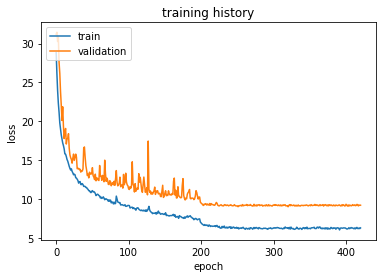

In [32]:
# train
history = model.fit(
    batch_size=8,             # adjust as training set expands
    validation_batch_size=2,  # adjust as training set expands
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,     # set to None for automatic determination
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');